In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [2]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [3]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'


In [5]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)



In [5]:
model_dir5 = directory1 + 'version5/model' #(P_11 and P_12)
model_dir13 = directory1  + 'version13/model' #(P_11)
model_dir19 = directory1  + 'version19/model' #(P_12)


In [6]:
model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr5 = InvertibleNetworkSurrogate.load(model_dir5, model_name, model_kwargs=kwargs)
surr13 = InvertibleNetworkSurrogate.load(model_dir13, model_name, model_kwargs=kwargs)
surr19 = InvertibleNetworkSurrogate.load(model_dir19, model_name, model_kwargs=kwargs)

#Load test data

In [7]:
test_datafile5 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile13 ='/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P11_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile19 = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P12_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'

qoi_test5 = pd.read_hdf(test_datafile5,key = 'qoi')
dvar_test5 = pd.read_hdf(test_datafile5,key = 'dvar')
qoi_test13 = pd.read_hdf(test_datafile13,key = 'qoi')
dvar_test13 = pd.read_hdf(test_datafile13,key = 'dvar')
qoi_test19 = pd.read_hdf(test_datafile19,key = 'qoi')
dvar_test19 = pd.read_hdf(test_datafile19,key = 'dvar')


Real measurement data

In [12]:
data_dir = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_april2022'
data_dir2 = '/data/user/boiger_r/aerosol/aerosol_data/real_measurement_data_november_2021'
data_dir1 = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021'
#phase_fun400_old = pd.read_csv(data_dir2+"/uNeph_PF_400nm_broad.csv")
#num_con = pd.read_csv(data_dir1+"/number_concentration.csv")
phase_fun400 = pd.read_csv(data_dir+"/uNeph_data_DEHS_400nm_updated_20220408.csv")
#phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")

#data_real_old = pd.read_csv(data_dir2+"/uNeph_GRASP_data.csv")

#"/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021/df_PF_Grasp_binned_P11P12_1wl.csv"



#phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")

#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [13]:
data_real = phase_fun400

In [11]:
data_real

angles    P11_uNeph  PPF_uNeph  P11_GRASP_lognorm  PPF_GRASP_lognorm
0     11.015809  2241.050494  -0.020354           1977.200           0.002675
1     12.001125  1870.119803   0.157820           1920.000           0.003139
2     12.983843  1797.460922   0.141974           1858.000           0.003628
3     13.963993  1776.953124   0.138444           1797.900           0.004142
4     14.941609  1960.508656  -0.027444           1734.000           0.004673
..          ...          ...        ...                ...                ...
154  165.744465    21.299880  -0.229356             21.255          -0.224510
155  166.743362    22.350774  -0.201907             21.728          -0.199310
156  167.745233    22.716065  -0.174176             22.212          -0.174280
157  168.750091    23.822497  -0.158986             22.702          -0.149820
158  169.757943    24.836465  -0.134028             23.190          -0.126320

[159 rows x 5 columns]

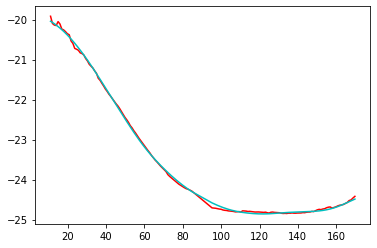

In [14]:
plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r',label = 'new data')
plt.plot(data_real['angles'],np.log(data_real['P11_GRASP_lognorm']*1e-12),'c',label = 'new data GRASP')
#plt.plot(data_real_old['angle'],np.log(data_real_old['P11_uNeph']*1e-12),'k',label= 'old data')


(array([-5.0e-10,  0.0e+00,  5.0e-10,  1.0e-09,  1.5e-09,  2.0e-09,
         2.5e-09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

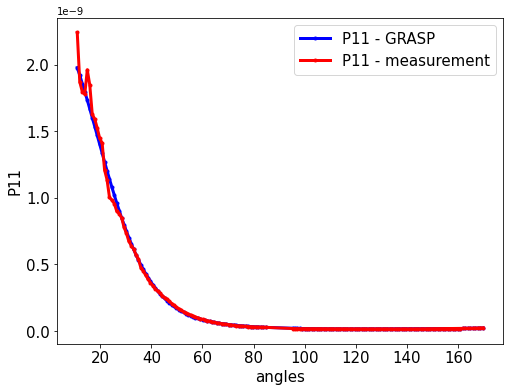

In [15]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],data_real['P11_GRASP_lognorm']*1e-12,'b.-', label = 'P11 - GRASP', linewidth = 3)
plt.plot(data_real['angles'],data_real['P11_uNeph']*1e-12,'r.-', label = 'P11 - measurement', linewidth = 3)
#plt.plot(data_real_old['angle'],(data_real_old['P11_uNeph']*1e-12),'k',label= 'old data', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('P11', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-26., -25., -24., -23., -22., -21., -20., -19.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

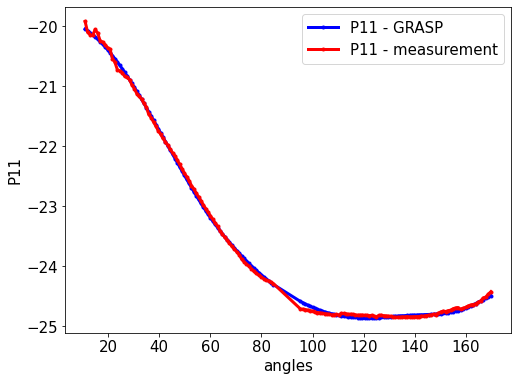

In [16]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],np.log(data_real['P11_GRASP_lognorm']*1e-12),'b.-', label = 'P11 - GRASP', linewidth = 3)
plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r.-', label = 'P11 - measurement', linewidth = 3)
#plt.plot(data_real_old['angle'],np.log((data_real_old['P11_uNeph']*1e-12)),'k',label= 'old data', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('P11', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-26., -25., -24., -23., -22., -21., -20., -19.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

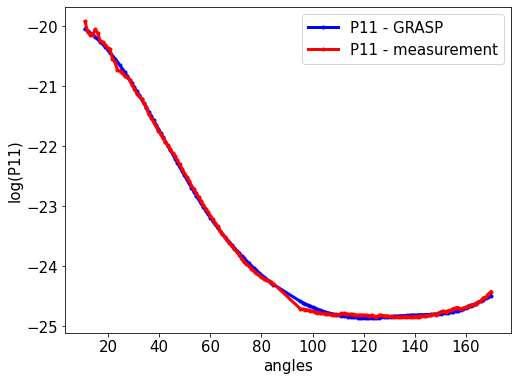

In [17]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],np.log(data_real['P11_GRASP_lognorm']*1e-12),'b.-', label = 'P11 - GRASP', linewidth = 3)
plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r.-', label = 'P11 - measurement', linewidth = 3)
plt.xlabel('angles', fontsize = 15)
plt.ylabel('log(P11)', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-6.e-13, -5.e-13, -4.e-13, -3.e-13, -2.e-13, -1.e-13,  0.e+00,
         1.e-13,  2.e-13]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

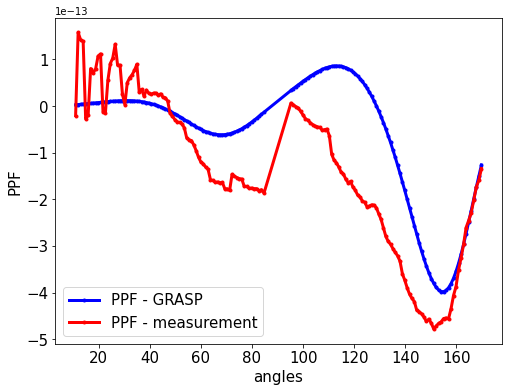

In [18]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],data_real['PPF_GRASP_lognorm']*1e-12,'b.-', label = 'PPF - GRASP', linewidth = 3)
plt.plot(data_real['angles'],data_real['PPF_uNeph']*1e-12,'r.-', label = 'PPF - measurement', linewidth = 3)
plt.xlabel('angles', fontsize = 15)
plt.ylabel('PPF', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)




# transform real measurement data to right format

In [19]:
from scipy.interpolate import interp1d

In [20]:
f_11 = interp1d(data_real['angles'],data_real['P11_uNeph'])
f_12 = interp1d(data_real['angles'],data_real['PPF_uNeph'])
f_11_GRASP = interp1d(data_real['angles'],data_real['P11_GRASP_lognorm'])
f_12_GRASP = interp1d(data_real['angles'],data_real['PPF_GRASP_lognorm'])

In [21]:
data_real

angles    P11_uNeph  PPF_uNeph  P11_GRASP_lognorm  PPF_GRASP_lognorm
0     11.015809  2241.050494  -0.020354           1977.200           0.002675
1     12.001125  1870.119803   0.157820           1920.000           0.003139
2     12.983843  1797.460922   0.141974           1858.000           0.003628
3     13.963993  1776.953124   0.138444           1797.900           0.004142
4     14.941609  1960.508656  -0.027444           1734.000           0.004673
..          ...          ...        ...                ...                ...
154  165.744465    21.299880  -0.229356             21.255          -0.224510
155  166.743362    22.350774  -0.201907             21.728          -0.199310
156  167.745233    22.716065  -0.174176             22.212          -0.174280
157  168.750091    23.822497  -0.158986             22.702          -0.149820
158  169.757943    24.836465  -0.134028             23.190          -0.126320

[159 rows x 5 columns]

In [22]:
angles_new = np.linspace(12,169,num = 158,endpoint = True)

(array([-26., -25., -24., -23., -22., -21., -20., -19.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

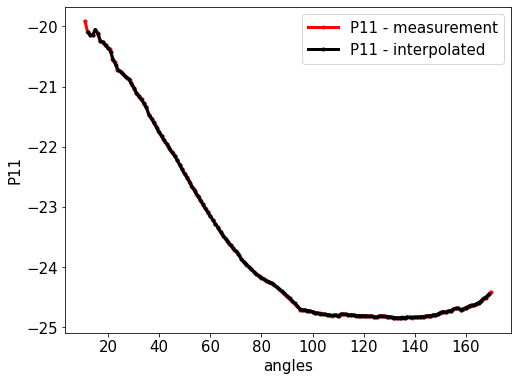

In [23]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r.-', label = 'P11 - measurement', linewidth = 3)
plt.plot(angles_new,np.log(f_11(angles_new)*1e-12),'k.-', label = 'P11 - interpolated', linewidth = 3)
plt.xlabel('angles', fontsize = 15)
plt.ylabel('P11', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


(array([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

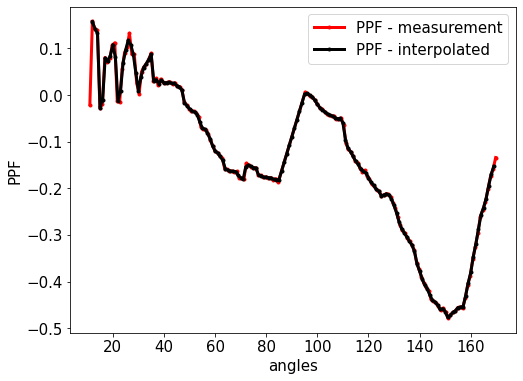

In [24]:
plt.figure(figsize = (8,6))

plt.plot(data_real['angles'],data_real['PPF_uNeph'],'r.-', label = 'PPF - measurement', linewidth = 3)
plt.plot(angles_new,f_12(angles_new),'k.-', label = 'PPF - interpolated', linewidth = 3)
plt.xlabel('angles', fontsize = 15)
plt.ylabel('PPF', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [25]:
# write new interpolated measurement data in dataframe

In [26]:
data400_P11 = pd.DataFrame(data=f_11(angles_new)).transpose()
data400_P12 = pd.DataFrame(data=f_12(angles_new)).transpose()
data400_P11_GRASP = pd.DataFrame(data=f_11_GRASP(angles_new)).transpose()
data400_P12_GRASP = pd.DataFrame(data=f_12_GRASP(angles_new)).transpose()


In [27]:
data_real['P11_uNeph']

0      2241.050494
1      1870.119803
2      1797.460922
3      1776.953124
4      1960.508656
          ...     
154      21.299880
155      22.350774
156      22.716065
157      23.822497
158      24.836465
Name: P11_uNeph, Length: 159, dtype: float64

In [28]:
data400_P11

0            1            2            3            4    \
0  1870.543404  1797.122872  1783.713698  1953.716714  1828.234631   

           5            6            7            8            9    ...  \
0  1622.847117  1581.550403  1510.340883  1439.394353  1359.484621  ...   

         148        149        150        151        152        153  \
0  19.179302  19.613803  19.907042  20.070588  20.387362  20.920212   

         154        155        156        157  
0  21.568717  22.444347  22.996584  24.073922  

[1 rows x 158 columns]

In [29]:
# Rename the columns
listindex_data1 = []
listindex_data2 = []
for i in range(len(angles_new)):
    listindex_data1.append("P11_0.532_"+str(int(angles_new[i])))
    listindex_data2.append("P12_0.532_"+str(int(angles_new[i])))

In [30]:
listindex_data1_GRASP = []
listindex_data2_GRASP = []
for i in range(len(angles_new)):
    listindex_data1_GRASP.append("P11_0.532_"+str(int(angles_new[i])))
    listindex_data2_GRASP.append("P12_0.532_"+str(int(angles_new[i])))

In [31]:
dicts_data_1 = {}
j = 0
for i in data400_P11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in data400_P12.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1

In [32]:
dicts_data_1_GRASP = {}
j = 0
for i in data400_P11_GRASP.columns:
    dicts_data_1_GRASP[i]=listindex_data1_GRASP[j]
    j=j+1
dicts_data_2_GRASP = {}
j = 0
for i in data400_P12_GRASP.columns:
    dicts_data_2_GRASP[i]=listindex_data2_GRASP[j]
    j=j+1

In [33]:
newdata400_P11 = data400_P11.rename(dicts_data_1, axis =1)
newdata400_P12 = data400_P12.rename(dicts_data_2, axis =1)

In [34]:
newdata400_P11_GRASP = data400_P11_GRASP.rename(dicts_data_1_GRASP, axis =1)
newdata400_P12_GRASP = data400_P12_GRASP.rename(dicts_data_2_GRASP, axis =1)

In [35]:
newdata400_P11 = newdata400_P11.rename({"P11_uNeph":'0'},axis=0)
newdata400_P12 = newdata400_P12.rename({"PPF_uNeph":'0'},axis=0)


In [36]:
newdata400_P11

P11_0.532_12  P11_0.532_13  P11_0.532_14  P11_0.532_15  P11_0.532_16  \
0   1870.543404   1797.122872   1783.713698   1953.716714   1828.234631   

   P11_0.532_17  P11_0.532_18  P11_0.532_19  P11_0.532_20  P11_0.532_21  ...  \
0   1622.847117   1581.550403   1510.340883   1439.394353   1359.484621  ...   

   P11_0.532_160  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      19.179302      19.613803      19.907042      20.070588      20.387362   

   P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  
0      20.920212      21.568717      22.444347      22.996584      24.073922  

[1 rows x 158 columns]

In [37]:
# add the missing points

In [38]:
newdata400_P11['P11_0.532_11'] = data_real['P11_uNeph'].iloc[0]
newdata400_P11['P11_0.532_170'] = data_real['P11_uNeph'].iloc[158]

newdata400_P11

P11_0.532_12  P11_0.532_13  P11_0.532_14  P11_0.532_15  P11_0.532_16  \
0   1870.543404   1797.122872   1783.713698   1953.716714   1828.234631   

   P11_0.532_17  P11_0.532_18  P11_0.532_19  P11_0.532_20  P11_0.532_21  ...  \
0   1622.847117   1581.550403   1510.340883   1439.394353   1359.484621  ...   

   P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  P11_0.532_166  \
0      19.907042      20.070588      20.387362      20.920212      21.568717   

   P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_11  P11_0.532_170  
0      22.444347      22.996584      24.073922   2241.050494      24.836465  

[1 rows x 160 columns]

In [39]:
newdata400_P12['P12_0.532_11'] = data_real['PPF_uNeph'].iloc[0]
newdata400_P12['P12_0.532_170'] = data_real['PPF_uNeph'].iloc[158]

newdata400_P11_GRASP['P11_0.532_11'] = data_real['P11_GRASP_lognorm'].iloc[0]
newdata400_P11_GRASP['P11_0.532_170'] = data_real['P11_GRASP_lognorm'].iloc[158]
newdata400_P12_GRASP['P12_0.532_11'] = data_real['PPF_GRASP_lognorm'].iloc[0]
newdata400_P12_GRASP['P12_0.532_170'] = data_real['PPF_GRASP_lognorm'].iloc[158]

newdata400_P11

P11_0.532_12  P11_0.532_13  P11_0.532_14  P11_0.532_15  P11_0.532_16  \
0   1870.543404   1797.122872   1783.713698   1953.716714   1828.234631   

   P11_0.532_17  P11_0.532_18  P11_0.532_19  P11_0.532_20  P11_0.532_21  ...  \
0   1622.847117   1581.550403   1510.340883   1439.394353   1359.484621  ...   

   P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  P11_0.532_166  \
0      19.907042      20.070588      20.387362      20.920212      21.568717   

   P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_11  P11_0.532_170  
0      22.444347      22.996584      24.073922   2241.050494      24.836465  

[1 rows x 160 columns]

In [40]:
# sort the columns
first_column = newdata400_P11.pop('P11_0.532_11')

newdata400_P11.insert(0, 'P11_0.532_11', first_column)
 


In [41]:
first_column = newdata400_P12.pop('P12_0.532_11')

newdata400_P12.insert(0, 'P12_0.532_11', first_column)

first_column = newdata400_P11_GRASP.pop('P11_0.532_11')

newdata400_P11_GRASP.insert(0, 'P11_0.532_11', first_column)
 
first_column = newdata400_P12_GRASP.pop('P12_0.532_11')

newdata400_P12_GRASP.insert(0, 'P12_0.532_11', first_column)




In [42]:
newdata400_P12

P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  P12_0.532_15  \
0     -0.020354      0.157617      0.141915      0.132334      -0.02697   

   P12_0.532_16  P12_0.532_17  P12_0.532_18  P12_0.532_19  P12_0.532_20  ...  \
0     -0.010984      0.079317      0.072289      0.084298      0.108046  ...   

   P12_0.532_161  P12_0.532_162  P12_0.532_163  P12_0.532_164  P12_0.532_165  \
0      -0.346421      -0.319343      -0.288306      -0.257018      -0.241612   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  
0      -0.222334      -0.194804      -0.170325      -0.152797      -0.134028  

[1 rows x 160 columns]

In [43]:
data_real

angles    P11_uNeph  PPF_uNeph  P11_GRASP_lognorm  PPF_GRASP_lognorm
0     11.015809  2241.050494  -0.020354           1977.200           0.002675
1     12.001125  1870.119803   0.157820           1920.000           0.003139
2     12.983843  1797.460922   0.141974           1858.000           0.003628
3     13.963993  1776.953124   0.138444           1797.900           0.004142
4     14.941609  1960.508656  -0.027444           1734.000           0.004673
..          ...          ...        ...                ...                ...
154  165.744465    21.299880  -0.229356             21.255          -0.224510
155  166.743362    22.350774  -0.201907             21.728          -0.199310
156  167.745233    22.716065  -0.174176             22.212          -0.174280
157  168.750091    23.822497  -0.158986             22.702          -0.149820
158  169.757943    24.836465  -0.134028             23.190          -0.126320

[159 rows x 5 columns]

In [44]:
# extrapolate the function to get the missing angles
def extrapolate(x,x2,x1,y2,y1):
    return y1+(x-x1)/(x2-x1)*(y2-y1)

In [45]:
newdata400_P11['P11_0.532_10']=extrapolate(10,11,12,newdata400_P11['P11_0.532_11'],newdata400_P11['P11_0.532_12'])
newdata400_P11['P11_0.532_9']=extrapolate(9,10,11,newdata400_P11['P11_0.532_10'],newdata400_P11['P11_0.532_11'])
newdata400_P11['P11_0.532_8']=extrapolate(8,9,10,newdata400_P11['P11_0.532_9'],newdata400_P11['P11_0.532_10'])
newdata400_P11['P11_0.532_7']=extrapolate(7,8,9,newdata400_P11['P11_0.532_8'],newdata400_P11['P11_0.532_9'])
newdata400_P11['P11_0.532_6']=extrapolate(6,7,8,newdata400_P11['P11_0.532_7'],newdata400_P11['P11_0.532_8'])
newdata400_P11['P11_0.532_5']=extrapolate(5,6,7,newdata400_P11['P11_0.532_6'],newdata400_P11['P11_0.532_7'])


In [46]:
newdata400_P11_GRASP['P11_0.532_10']=extrapolate(10,11,12,newdata400_P11_GRASP['P11_0.532_11'],newdata400_P11_GRASP['P11_0.532_12'])
newdata400_P11_GRASP['P11_0.532_9']=extrapolate(9,10,11,newdata400_P11_GRASP['P11_0.532_10'],newdata400_P11_GRASP['P11_0.532_11'])
newdata400_P11_GRASP['P11_0.532_8']=extrapolate(8,9,10,newdata400_P11_GRASP['P11_0.532_9'],newdata400_P11_GRASP['P11_0.532_10'])
newdata400_P11_GRASP['P11_0.532_7']=extrapolate(7,8,9,newdata400_P11_GRASP['P11_0.532_8'],newdata400_P11_GRASP['P11_0.532_9'])
newdata400_P11_GRASP['P11_0.532_6']=extrapolate(6,7,8,newdata400_P11_GRASP['P11_0.532_7'],newdata400_P11_GRASP['P11_0.532_8'])
newdata400_P11_GRASP['P11_0.532_5']=extrapolate(5,6,7,newdata400_P11_GRASP['P11_0.532_6'],newdata400_P11_GRASP['P11_0.532_7'])


In [47]:
newdata400_P12['P12_0.532_10']=extrapolate(10,11,12,newdata400_P12['P12_0.532_11'],newdata400_P12['P12_0.532_12'])
newdata400_P12['P12_0.532_9']=extrapolate(9,10,11,newdata400_P12['P12_0.532_10'],newdata400_P12['P12_0.532_11'])
newdata400_P12['P12_0.532_8']=extrapolate(8,9,10,newdata400_P12['P12_0.532_9'],newdata400_P12['P12_0.532_10'])
newdata400_P12['P12_0.532_7']=extrapolate(7,8,9,newdata400_P12['P12_0.532_8'],newdata400_P12['P12_0.532_9'])
newdata400_P12['P12_0.532_6']=extrapolate(6,7,8,newdata400_P12['P12_0.532_7'],newdata400_P12['P12_0.532_8'])
newdata400_P12['P12_0.532_5']=extrapolate(5,6,7,newdata400_P12['P12_0.532_6'],newdata400_P12['P12_0.532_7'])


In [48]:
newdata400_P12_GRASP['P12_0.532_10']=extrapolate(10,11,12,newdata400_P12_GRASP['P12_0.532_11'],newdata400_P12_GRASP['P12_0.532_12'])
newdata400_P12_GRASP['P12_0.532_9']=extrapolate(9,10,11,newdata400_P12_GRASP['P12_0.532_10'],newdata400_P12_GRASP['P12_0.532_11'])
newdata400_P12_GRASP['P12_0.532_8']=extrapolate(8,9,10,newdata400_P12_GRASP['P12_0.532_9'],newdata400_P12_GRASP['P12_0.532_10'])
newdata400_P12_GRASP['P12_0.532_7']=extrapolate(7,8,9,newdata400_P12_GRASP['P12_0.532_8'],newdata400_P12_GRASP['P12_0.532_9'])
newdata400_P12_GRASP['P12_0.532_6']=extrapolate(6,7,8,newdata400_P12_GRASP['P12_0.532_7'],newdata400_P12_GRASP['P12_0.532_8'])
newdata400_P12_GRASP['P12_0.532_5']=extrapolate(5,6,7,newdata400_P12_GRASP['P12_0.532_6'],newdata400_P12_GRASP['P12_0.532_7'])


In [49]:
first_column = newdata400_P11.pop('P11_0.532_10')
newdata400_P11.insert(0, 'P11_0.532_10', first_column)
first_column = newdata400_P11.pop('P11_0.532_9')
newdata400_P11.insert(0, 'P11_0.532_9', first_column)
first_column = newdata400_P11.pop('P11_0.532_8')
newdata400_P11.insert(0, 'P11_0.532_8', first_column)
first_column = newdata400_P11.pop('P11_0.532_7')
newdata400_P11.insert(0, 'P11_0.532_7', first_column)
first_column = newdata400_P11.pop('P11_0.532_6')
newdata400_P11.insert(0, 'P11_0.532_6', first_column)
first_column = newdata400_P11.pop('P11_0.532_5')
newdata400_P11.insert(0, 'P11_0.532_5', first_column)



In [50]:
first_column = newdata400_P12.pop('P12_0.532_10')
newdata400_P12.insert(0, 'P12_0.532_10', first_column)
first_column = newdata400_P12.pop('P12_0.532_9')
newdata400_P12.insert(0, 'P12_0.532_9', first_column)
first_column = newdata400_P12.pop('P12_0.532_8')
newdata400_P12.insert(0, 'P12_0.532_8', first_column)
first_column = newdata400_P12.pop('P12_0.532_7')
newdata400_P12.insert(0, 'P12_0.532_7', first_column)
first_column = newdata400_P12.pop('P12_0.532_6')
newdata400_P12.insert(0, 'P12_0.532_6', first_column)
first_column = newdata400_P12.pop('P12_0.532_5')
newdata400_P12.insert(0, 'P12_0.532_5', first_column)


In [51]:
first_column = newdata400_P11_GRASP.pop('P11_0.532_10')
newdata400_P11_GRASP.insert(0, 'P11_0.532_10', first_column)
first_column = newdata400_P11_GRASP.pop('P11_0.532_9')
newdata400_P11_GRASP.insert(0, 'P11_0.532_9', first_column)
first_column = newdata400_P11_GRASP.pop('P11_0.532_8')
newdata400_P11_GRASP.insert(0, 'P11_0.532_8', first_column)
first_column = newdata400_P11_GRASP.pop('P11_0.532_7')
newdata400_P11_GRASP.insert(0, 'P11_0.532_7', first_column)
first_column = newdata400_P11_GRASP.pop('P11_0.532_6')
newdata400_P11_GRASP.insert(0, 'P11_0.532_6', first_column)
first_column = newdata400_P11_GRASP.pop('P11_0.532_5')
newdata400_P11_GRASP.insert(0, 'P11_0.532_5', first_column)


In [52]:
first_column = newdata400_P12_GRASP.pop('P12_0.532_10')
newdata400_P12_GRASP.insert(0, 'P12_0.532_10', first_column)
first_column = newdata400_P12_GRASP.pop('P12_0.532_9')
newdata400_P12_GRASP.insert(0, 'P12_0.532_9', first_column)
first_column = newdata400_P12_GRASP.pop('P12_0.532_8')
newdata400_P12_GRASP.insert(0, 'P12_0.532_8', first_column)
first_column = newdata400_P12_GRASP.pop('P12_0.532_7')
newdata400_P12_GRASP.insert(0, 'P12_0.532_7', first_column)
first_column = newdata400_P12_GRASP.pop('P12_0.532_6')
newdata400_P12_GRASP.insert(0, 'P12_0.532_6', first_column)
first_column = newdata400_P12_GRASP.pop('P12_0.532_5')
newdata400_P12_GRASP.insert(0, 'P12_0.532_5', first_column)


In [53]:
newdata400_P11['P11_0.532_171']=extrapolate(171,170,169,newdata400_P11['P11_0.532_170'],newdata400_P11['P11_0.532_169'])
newdata400_P11['P11_0.532_172']=extrapolate(172,171,170,newdata400_P11['P11_0.532_171'],newdata400_P11['P11_0.532_170'])
newdata400_P11['P11_0.532_173']=extrapolate(173,172,171,newdata400_P11['P11_0.532_172'],newdata400_P11['P11_0.532_171'])
newdata400_P11['P11_0.532_174']=extrapolate(174,173,172,newdata400_P11['P11_0.532_173'],newdata400_P11['P11_0.532_172'])
newdata400_P11['P11_0.532_175']=extrapolate(175,174,173,newdata400_P11['P11_0.532_174'],newdata400_P11['P11_0.532_173'])




In [54]:
newdata400_P12['P12_0.532_171']=extrapolate(171,170,169,newdata400_P12['P12_0.532_170'],newdata400_P12['P12_0.532_169'])
newdata400_P12['P12_0.532_172']=extrapolate(172,171,170,newdata400_P12['P12_0.532_171'],newdata400_P12['P12_0.532_170'])
newdata400_P12['P12_0.532_173']=extrapolate(173,172,171,newdata400_P12['P12_0.532_172'],newdata400_P12['P12_0.532_171'])
newdata400_P12['P12_0.532_174']=extrapolate(174,173,172,newdata400_P12['P12_0.532_173'],newdata400_P12['P12_0.532_172'])
newdata400_P12['P12_0.532_175']=extrapolate(175,174,173,newdata400_P12['P12_0.532_174'],newdata400_P12['P12_0.532_173'])



In [55]:
newdata400_P11_GRASP['P11_0.532_171']=extrapolate(171,170,169,newdata400_P11_GRASP['P11_0.532_170'],newdata400_P11_GRASP['P11_0.532_169'])
newdata400_P11_GRASP['P11_0.532_172']=extrapolate(172,171,170,newdata400_P11_GRASP['P11_0.532_171'],newdata400_P11_GRASP['P11_0.532_170'])
newdata400_P11_GRASP['P11_0.532_173']=extrapolate(173,172,171,newdata400_P11_GRASP['P11_0.532_172'],newdata400_P11_GRASP['P11_0.532_171'])
newdata400_P11_GRASP['P11_0.532_174']=extrapolate(174,173,172,newdata400_P11_GRASP['P11_0.532_173'],newdata400_P11_GRASP['P11_0.532_172'])
newdata400_P11_GRASP['P11_0.532_175']=extrapolate(175,174,173,newdata400_P11_GRASP['P11_0.532_174'],newdata400_P11_GRASP['P11_0.532_173'])




In [56]:
newdata400_P12_GRASP['P12_0.532_171']=extrapolate(171,170,169,newdata400_P12_GRASP['P12_0.532_170'],newdata400_P12_GRASP['P12_0.532_169'])
newdata400_P12_GRASP['P12_0.532_172']=extrapolate(172,171,170,newdata400_P12_GRASP['P12_0.532_171'],newdata400_P12_GRASP['P12_0.532_170'])
newdata400_P12_GRASP['P12_0.532_173']=extrapolate(173,172,171,newdata400_P12_GRASP['P12_0.532_172'],newdata400_P12_GRASP['P12_0.532_171'])
newdata400_P12_GRASP['P12_0.532_174']=extrapolate(174,173,172,newdata400_P12_GRASP['P12_0.532_173'],newdata400_P12_GRASP['P12_0.532_172'])
newdata400_P12_GRASP['P12_0.532_175']=extrapolate(175,174,173,newdata400_P12_GRASP['P12_0.532_174'],newdata400_P12_GRASP['P12_0.532_173'])



In [57]:
newdata400_P11 = newdata400_P11.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_90','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)


In [58]:

newdata400_P11_GRASP = newdata400_P11_GRASP.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_90','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)

newdata400_P12 = newdata400_P12.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_90','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)

newdata400_P12_GRASP = newdata400_P12_GRASP.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_90','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)




In [59]:
# create vector with angles according to NN
angles_NN_1 = np.arange(5,85)
angles_NN_1
angles_NN_2 = np.arange(96, 176)
angles_NN_2
angles_NN = np.concatenate((angles_NN_1.T, angles_NN_2.T))
angles_NN

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175])

(array([-26., -25., -24., -23., -22., -21., -20., -19., -18.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

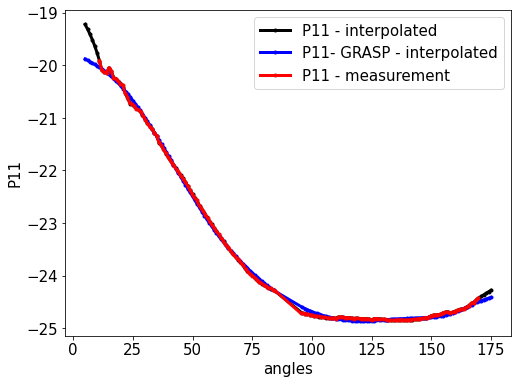

In [60]:
plt.figure(figsize = (8,6))

plt.plot(angles_NN,np.log(newdata400_P11.iloc[0]*1e-12),'k.-', label = 'P11 - interpolated', linewidth = 3)
plt.plot(angles_NN,np.log(newdata400_P11_GRASP.iloc[0]*1e-12),'b.-', label = 'P11- GRASP - interpolated', linewidth = 3)

plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r.-', label = 'P11 - measurement', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('P11', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

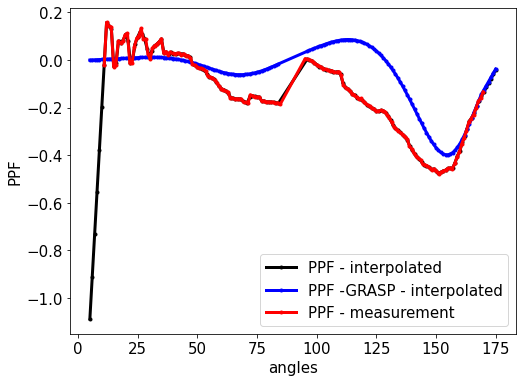

In [61]:
plt.figure(figsize = (8,6))

plt.plot(angles_NN,newdata400_P12.iloc[0],'k.-', label = 'PPF - interpolated', linewidth = 3)
plt.plot(angles_NN,newdata400_P12_GRASP.iloc[0],'b.-', label = 'PPF -GRASP - interpolated', linewidth = 3)

plt.plot(data_real['angles'],data_real['PPF_uNeph'],'r.-', label = 'PPF - measurement', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('PPF', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [62]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test5.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test5.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

In [63]:
# since the above extrapolation is questionable, we take the extrapolation from GRASP
newdata400_P11['P11_0.532_5'] = newdata400_P11_GRASP['P11_0.532_5']
newdata400_P11['P11_0.532_6'] = newdata400_P11_GRASP['P11_0.532_6']
newdata400_P11['P11_0.532_7'] = newdata400_P11_GRASP['P11_0.532_7']
newdata400_P11['P11_0.532_8'] = newdata400_P11_GRASP['P11_0.532_8']
newdata400_P11['P11_0.532_9'] = newdata400_P11_GRASP['P11_0.532_9']
newdata400_P11['P11_0.532_10'] = newdata400_P11_GRASP['P11_0.532_10']



newdata400_P11['P11_0.532_171'] = newdata400_P11_GRASP['P11_0.532_171']
newdata400_P11['P11_0.532_172'] = newdata400_P11_GRASP['P11_0.532_172']
newdata400_P11['P11_0.532_173'] = newdata400_P11_GRASP['P11_0.532_173']
newdata400_P11['P11_0.532_174'] = newdata400_P11_GRASP['P11_0.532_174']
newdata400_P11['P11_0.532_175'] = newdata400_P11_GRASP['P11_0.532_175']


In [64]:
newdata400_P12['P12_0.532_5'] = newdata400_P12_GRASP['P12_0.532_5']
newdata400_P12['P12_0.532_6'] = newdata400_P12_GRASP['P12_0.532_6']
newdata400_P12['P12_0.532_7'] = newdata400_P12_GRASP['P12_0.532_7']
newdata400_P12['P12_0.532_8'] = newdata400_P12_GRASP['P12_0.532_8']
newdata400_P12['P12_0.532_9'] = newdata400_P12_GRASP['P12_0.532_9']
newdata400_P12['P12_0.532_10'] = newdata400_P12_GRASP['P12_0.532_10']


newdata400_P12['P12_0.532_171'] = newdata400_P12_GRASP['P12_0.532_171']
newdata400_P12['P12_0.532_172'] = newdata400_P12_GRASP['P12_0.532_172']
newdata400_P12['P12_0.532_173'] = newdata400_P12_GRASP['P12_0.532_173']
newdata400_P12['P12_0.532_174'] = newdata400_P12_GRASP['P12_0.532_174']
newdata400_P12['P12_0.532_175'] = newdata400_P12_GRASP['P12_0.532_175']


In [65]:
newdata400_P11_GRASP

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0  2320.008067   2262.87339  2205.738712  2148.604034  2091.469356   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0   2034.334678        1977.2   1920.065322   1857.009312   1795.546485  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0      21.376002      21.851981      22.336232      22.823005          23.19   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0      23.556995      23.923989      24.290984      24.657978      25.024973  

[1 rows x 160 columns]

(array([-26., -25., -24., -23., -22., -21., -20., -19.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

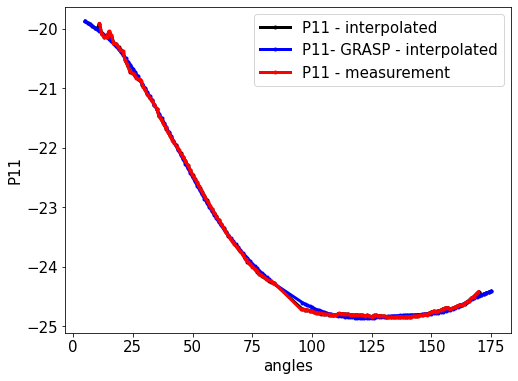

In [66]:
plt.figure(figsize = (8,6))

plt.plot(angles_NN,np.log(newdata400_P11.iloc[0]*1e-12),'k.-', label = 'P11 - interpolated', linewidth = 3)
plt.plot(angles_NN,np.log(newdata400_P11_GRASP.iloc[0]*1e-12),'b.-', label = 'P11- GRASP - interpolated', linewidth = 3)

plt.plot(data_real['angles'],np.log(data_real['P11_uNeph']*1e-12),'r.-', label = 'P11 - measurement', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('P11', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

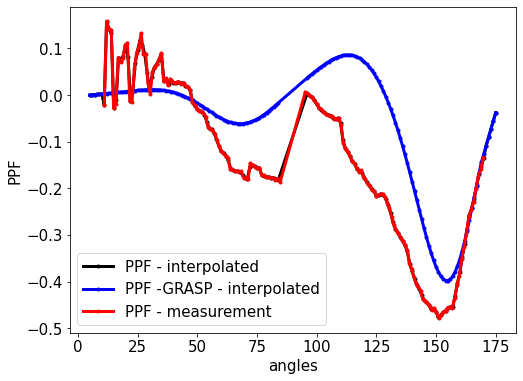

In [67]:
plt.figure(figsize = (8,6))

plt.plot(angles_NN,newdata400_P12.iloc[0],'k.-', label = 'PPF - interpolated', linewidth = 3)
plt.plot(angles_NN,newdata400_P12_GRASP.iloc[0],'b.-', label = 'PPF -GRASP - interpolated', linewidth = 3)

plt.plot(data_real['angles'],data_real['PPF_uNeph'],'r.-', label = 'PPF - measurement', linewidth = 3)

plt.xlabel('angles', fontsize = 15)
plt.ylabel('PPF', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [171]:
# prepare the dataframes for retrieval with the different methods
phase400new5 = pd.concat([np.log(newdata400_P11*1e-12),newdata400_P12],axis =1)
phase400new13 = np.log(newdata400_P11*1e-12)
phase400new19 = newdata400_P12

In [172]:
phase400new5

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -15.276525    -15.30146   -15.327033   -15.353277   -15.380229   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -15.407927    -15.311151    -15.491867    -15.531909    -15.539398  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.222334      -0.194804      -0.170325      -0.152797      -0.134028   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.108647      -0.090974      -0.073301      -0.055628      -0.037956  

[1 rows x 320 columns]

# Reformatted Real Measurement data

# Predict dvar from measurement data

In [173]:
# Only P11
dvar_pred_iv5 = surr5.sample_n_tries(phase400new5.values, batch_size=128, n_tries=32)
# P11 and PPF
dvar_pred_iv13 = surr13.sample_n_tries(phase400new13.values, batch_size=128, n_tries=32)
# Only PPF
dvar_pred_iv19 = surr19.sample_n_tries(phase400new19.values, batch_size=128, n_tries=32)


In [174]:
dvar_pred_iv13 = pd.DataFrame(data=dvar_pred_iv13, columns=dvar_test5.columns)
dvar_pred_iv13

V_tot  R_median      GSD         n     k_532
0  2468.4499    0.3284  1.41653  1.386661  0.014289

In [175]:
dvar_pred_iv5 = pd.DataFrame(data=dvar_pred_iv5, columns=dvar_test5.columns)
dvar_pred_iv5

V_tot  R_median       GSD         n    k_532
0  6560.242765  2.353516  1.485367  1.645676  0.10579

In [176]:
dvar_pred_iv19 = pd.DataFrame(data=dvar_pred_iv19, columns=dvar_test19.columns)
dvar_pred_iv19

V_tot  R_median       GSD         n     k_532
0  6559.693387  2.088333  1.412519  1.516904  0.015431

# Compare to true values

In [177]:
# True values
Parameters1 = pd.DataFrame([])
n = 1.45
k = 1e-5
m = n+1j*k
sigma = np.exp(0.262) #1.4
rmean = 0.25 #0.4
Vtot = 20.106
wavelength = 532
#Parameters1['RealRefractiveIndex']=[n]
#Parameters1['ImaginaryRefractiveIndex']= k
#Parameters1['Sigma']=sigma
#Parameters1['MeanRadius']=rmean
#Parameters1['VolumeConcentration']=Vtot

# GRASP P11 retrieval
Parameters2 = pd.DataFrame([])
n2 = 1.44738
k2 = 0.29496E-03
Vtot2 = 20.15
rmean2 = 0.26567
sigma2 = 1.28

# GRASP P11, PPF retrieval
Parameters3 = pd.DataFrame([])
n3 = 1.44749
k3 = 0.17341E-03
Vtot3 = 20.13
rmean3 = 0.265
sigma3 = 1.27

In [178]:
Parameters1['V_tot']=[Vtot]
Parameters1['R_median']=rmean
Parameters1['GSD']=sigma
Parameters1['n']=n
Parameters1['k_532']=k

Parameters2['V_tot']=[Vtot2]
Parameters2['R_median']=rmean2
Parameters2['GSD']=sigma2
Parameters2['n']=n2
Parameters2['k_532']=k2

Parameters3['V_tot']=[Vtot3]
Parameters3['R_median']=rmean3
Parameters3['GSD']=sigma3
Parameters3['n']=n3
Parameters3['k_532']=k3

#Parameters3['V_tot']=[27.705646]
#Parameters3['R_median']=0.392594 
#Parameters3['GSD']=1.422337
#Parameters3['n']=n
#Parameters3['k_532']=0.012761



In [179]:
Parameters1

V_tot  R_median       GSD     n    k_532
0  20.106      0.25  1.299527  1.45  0.00001

In [180]:
Parameters2

V_tot  R_median   GSD        n     k_532
0  20.15   0.26567  1.28  1.44738  0.000295

In [181]:
np.exp(0.262)

1.2995265424293818

In [182]:
Parameters3

V_tot  R_median   GSD        n     k_532
0  20.13     0.265  1.27  1.44749  0.000173

In [183]:
dvar_pred_iv13

V_tot  R_median      GSD         n     k_532
0  2468.4499    0.3284  1.41653  1.386661  0.014289

In [184]:
dvar_pred_iv5

V_tot  R_median       GSD         n    k_532
0  6560.242765  2.353516  1.485367  1.645676  0.10579

In [185]:
dvar_pred_iv19

V_tot  R_median       GSD         n     k_532
0  6559.693387  2.088333  1.412519  1.516904  0.015431

In [186]:
# Parameter k_532 and GSD is not included in the original data set. 

In [187]:
# Plot the size distributions

In [188]:
def pdf(Vtot, x, mu, sigma):
    return Vtot/(np.sqrt(2*np.pi)*np.log(sigma))*np.exp(-(np.log(x)-np.log(mu))**2.0/(2*(np.log(sigma))**2.0))

$sizedistr(x)=\frac{ V_{tot}}{( \log(GSD) \sqrt{2 \pi})}\exp(\frac{-\log(x)-\log(R_{mean})^2} {(2 \log(GSD)^2)})$

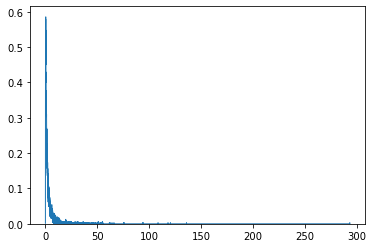

In [189]:

mu1 = Parameters1['R_median'][0]
sigma1 = Parameters1['GSD'][0]
Vtot1 = Parameters1['V_tot'][0]
s1 = np.random.lognormal(mu1, sigma1, 10000)   
count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid',histtype = 'step')
x1 = np.linspace(min(bins1), max(bins1), 100000)
#pdf1 = Vtot1*(np.exp(-(np.log(x1) - np.log(mu1))**2 / (2 * sigma1**2)) / ( sigma1 * np.sqrt(2 * np.pi)))
pdf1 = pdf(Vtot1,x1,mu1,sigma1)

#fig, ax = plt.subplots(figsize = (10,10))
#ax.plot(x1,pdf1)
#ax.set_xscale('log')

In [190]:
x_new =np.array([ 0.0655,0.0679,0.07035,0.07295,0.0756,0.07840000000000000,0.08125,0.08425,0.08735,0.09055000000000000,0.09385000000000000,0.0973,0.10085,0.10455,0.10835000000000000,0.11235000000000000,0.11645,0.1207,0.12515,0.12975,0.1345,0.1394,0.1445,0.14980000000000000,0.15530000000000000,0.161,0.1669,0.173,0.179350,0.1859,0.19270,0.19975,0.2071,0.2147,0.22255,0.2307,0.23915,0.2479,0.257,0.26640000000000000,0.27615000000000000,0.28625,0.29675,0.30765,0.31890000000000000,0.3306,0.3427,0.35525,0.36825,0.38175,0.39575,0.41025,0.42525,0.44085,0.457,0.47375])

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

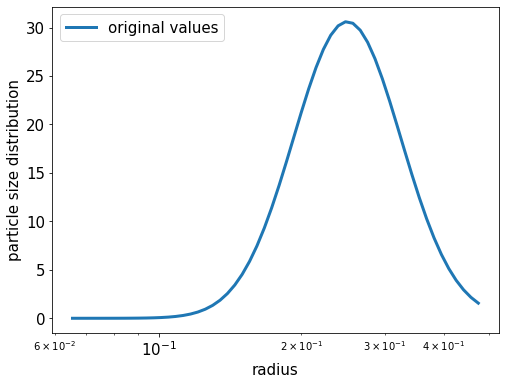

In [191]:
pdf1 = pdf(Vtot1,x_new,mu1,sigma1)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(x_new,pdf1, label='original values', linewidth =3)
ax.set_xscale('log')

plt.xlabel('radius', fontsize = 15)
plt.ylabel('particle size distribution', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

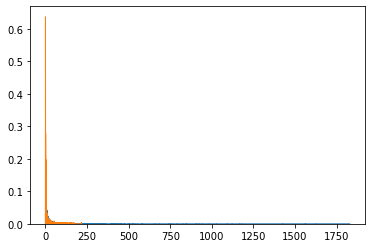

In [192]:

mu2 = dvar_pred_iv5['R_median'][0]
sigma2 = dvar_pred_iv5['GSD'][0]
Vtot2 = dvar_pred_iv5['V_tot'][0]
s2 = np.random.lognormal(mu2, sigma2, 10000)   
count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid',histtype = 'step')
x2 = np.linspace(min(bins2), max(bins2), 100000)
#pdf2 = Vtot2*(np.exp(-(np.log(x2) - np.log(mu2))**2 / (2 * sigma2**2)) / (sigma2 * np.sqrt(2 * np.pi)))
pdf2 = pdf(Vtot2,x_new,mu2,sigma2)

mu3 = dvar_pred_iv13['R_median'][0]
sigma3 = dvar_pred_iv13['GSD'][0]
Vtot3 = dvar_pred_iv13['V_tot'][0]
s3 = np.random.lognormal(mu3, sigma3, 10000)   
count3, bins3, ignored3 = plt.hist(s3, 10000, density=True, align='mid',histtype = 'step')
x3 = np.linspace(min(bins3), max(bins3), 100000)
#pdf3 = Vtot3*(np.exp(-(np.log(x3) - np.log(mu3))**2 / (2 * sigma3**2)) / (sigma3 * np.sqrt(2 * np.pi)))
pdf3 = pdf(Vtot3,x_new,mu3,sigma3)




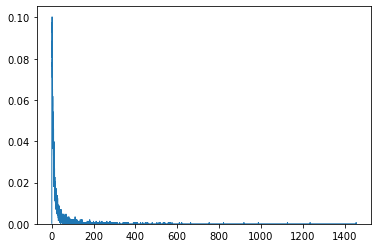

In [193]:
mu4 = dvar_pred_iv19['R_median'][0]
sigma4 = dvar_pred_iv19['GSD'][0]
Vtot4 = dvar_pred_iv19['V_tot'][0]
s4 = np.random.lognormal(mu4, sigma4, 10000)   
count4, bins4, ignored4 = plt.hist(s4, 10000, density=True, align='mid',histtype = 'step')
x4 = np.linspace(min(bins4), max(bins4), 100000)
#pdf4 = Vtot4*(np.exp(-(np.log(x4) - np.log(mu1))**2 / (2 * sigma4**2)) / (sigma4 * np.sqrt(2 * np.pi)))
pdf4 = pdf(Vtot4,x_new,mu4,sigma4)




(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

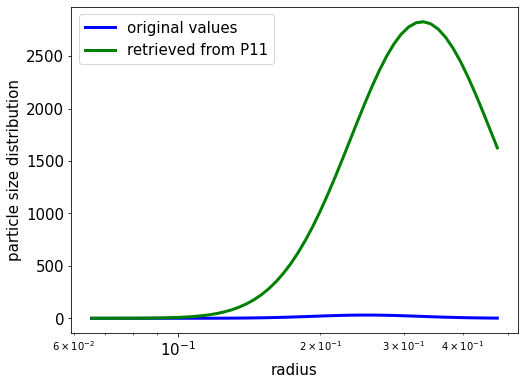

In [194]:


fig, ax = plt.subplots(figsize = (8,6))
#ax.plot(x_new,pdf2,'r', label = 'retrieved from P11 and PPF', linewidth = 3)
ax.plot(x_new,pdf1,'b', label = 'original values', linewidth = 3)
ax.plot(x_new,pdf3,'g', label = 'retrieved from P11', linewidth = 3)
#ax.plot(x_new,pdf4,'k',label = 'retrieved from PPF', linewidth = 3)
ax.set_xscale('log')
plt.xlabel('radius', fontsize = 15)
plt.ylabel('particle size distribution', fontsize= 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

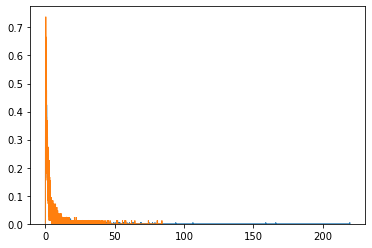

In [195]:
mu1_2 = Parameters2['R_median'][0]
sigma1_2 = Parameters2['GSD'][0]
Vtot1_2 = Parameters2['V_tot'][0]
s1_2 = np.random.lognormal(mu1_2, sigma1_2, 10000)   
count1_2, bins1_2, ignored1_2 = plt.hist(s1_2, 10000, density=True, align='mid',histtype = 'step')
x1_2 = np.linspace(min(bins1_2), max(bins1_2), 100000)
#pdf1_2 = Vtot1_2*(np.exp(-(np.log(x1_2) - np.log(mu1_2))**2 / (2 * sigma1_2**2)) / ( sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_2 = pdf(Vtot1_2,x_new,mu1_2,sigma1_2)


mu1_3 = Parameters3['R_median'][0]
sigma1_3 = Parameters3['GSD'][0]
Vtot1_3 = Parameters3['V_tot'][0]
s1_3 = np.random.lognormal(mu1_3, sigma1_3, 10000)   
count1_3, bins1_3, ignored1_3 = plt.hist(s1_3, 10000, density=True, align='mid',histtype = 'step')
x1_3 = np.linspace(min(bins1_3), max(bins1_3), 100000)
#pdf1_3 = Vtot1_3*(np.exp(-(np.log(x1_3) - np.log(mu1_3))**2 / (2 * sigma1_3**2)) / (sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_3 = pdf(Vtot1_3,x_new,mu1_3,sigma1_3)



(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

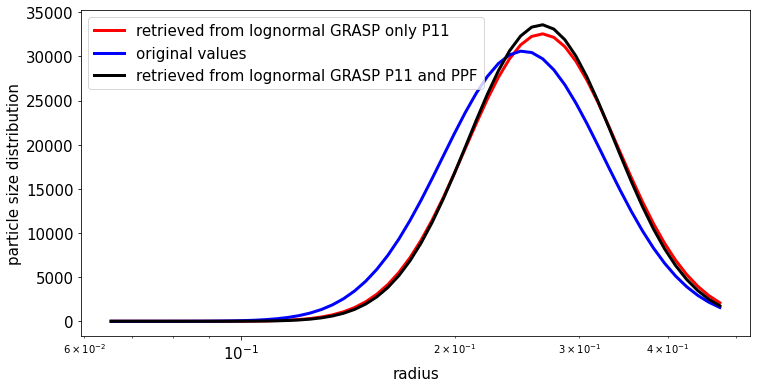

In [196]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(x_new,pdf1_2*1000,'r', linewidth = 3, label = 'retrieved from lognormal GRASP only P11')
ax.plot(x_new,pdf1*1000,'b', linewidth = 3, label = 'original values')

ax.plot(x_new,pdf1_3*1000,'k', linewidth = 3, label = 'retrieved from lognormal GRASP P11 and PPF')

ax.set_xscale('log')
plt.xlabel('radius', fontsize = 15)
plt.ylabel('particle size distribution', fontsize= 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Text(0, 0.5, 'dV/dlog(r)')

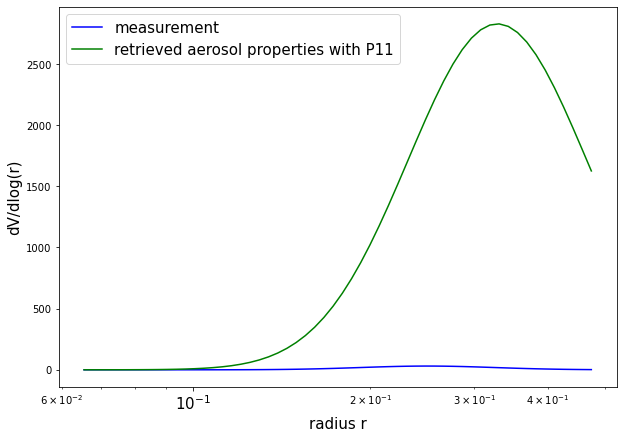

In [197]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 )
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

Text(0, 0.5, 'dV/dlog(r)')

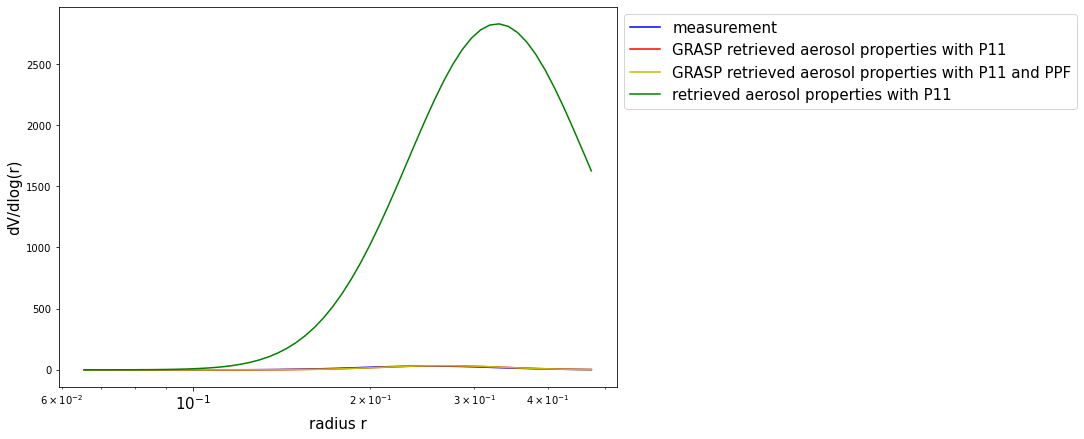

In [198]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf1_2,'r',label='GRASP retrieved aerosol properties with P11')
ax.plot(x_new,pdf1_3,'y',label='GRASP retrieved aerosol properties with P11 and PPF')

ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 , bbox_to_anchor=(1,1))
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

# Recompute phase functions

In [199]:
qoi_pred_iv_meas13_P1 = surr13.predict(Parameters1)
qoi_pred_iv_meas13_P1 =pd.DataFrame(qoi_pred_iv_meas13_P1,columns= qoi_test13.columns)


qoi_pred_iv_meas5 = surr5.predict(dvar_pred_iv5)
qoi_pred_iv_meas5 =pd.DataFrame(qoi_pred_iv_meas5,columns= qoi_test5.columns)

qoi_pred_iv_meas13 = surr13.predict(dvar_pred_iv13)
qoi_pred_iv_meas13 =pd.DataFrame(qoi_pred_iv_meas13,columns= qoi_test13.columns)

qoi_pred_iv_meas19 = surr19.predict(dvar_pred_iv19)
qoi_pred_iv_meas19 =pd.DataFrame(qoi_pred_iv_meas19,columns= qoi_test19.columns)


(array([-21., -20., -19., -18., -17., -16., -15., -14.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

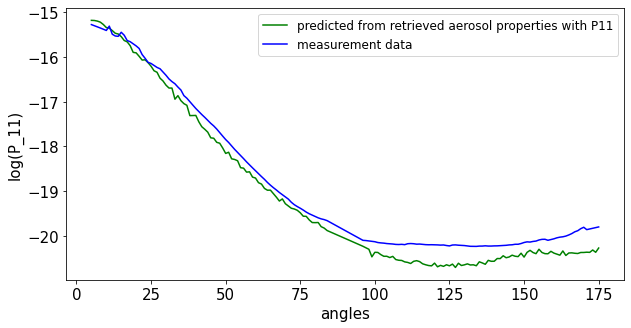

In [202]:
plt.figure(figsize =(10,5))
#plt.plot(angles_NN,qoi_pred_iv_meas5[P11_column_names].iloc[0],'k',label="predicted from retrieved aerosol properties with P11 and PPF")

#plt.plot(angles_NN,qoi_pred_iv_meas13_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11")
plt.plot(angles_NN,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_NN,np.log(newdata400_P11[P11_column_names]*1e-12).iloc[0],'b',label= "measurement data")

#plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal with P11")
#plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned with P11")
plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

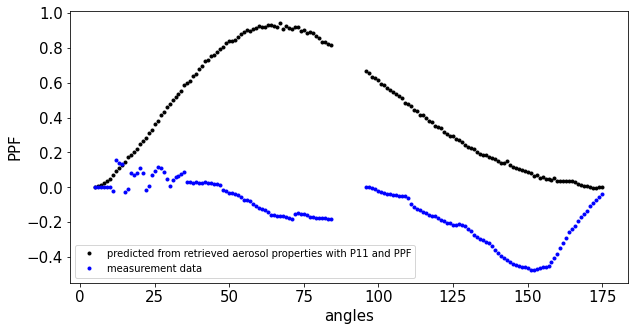

In [203]:
plt.figure(figsize =(10,5))
plt.plot(angles_NN,qoi_pred_iv_meas5[P12_column_names].iloc[0],'k.',label="predicted from retrieved aerosol properties with P11 and PPF")

#plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
#plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_NN,newdata400_P12[P12_column_names].iloc[0],'b.',label= "measurement data")


#plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
#plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=10)
plt.ylabel("PPF",fontsize=15)
plt.xlabel("angles",fontsize=15)




plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

